<a href="https://colab.research.google.com/github/ahzaidy/Programs/blob/main/CPSC_5410_HW1_P4_BO_LCB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

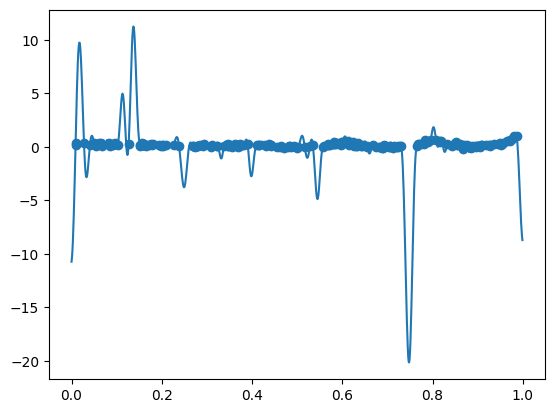

>x=0.745, f()=-18.464, actual=0.108
>x=0.000, f()=-10.663, actual=0.445
>x=0.247, f()=-3.391, actual=-0.029
>x=0.993, f()=-4.259, actual=1.054
>x=0.547, f()=-4.635, actual=0.014
>x=0.400, f()=-2.649, actual=0.477
>x=0.032, f()=-3.900, actual=0.452
>x=0.004, f()=-4.155, actual=0.367
>x=0.755, f()=-2.889, actual=0.172
>x=0.738, f()=-2.489, actual=0.056
>x=0.122, f()=-0.117, actual=0.242
>x=0.660, f()=-0.617, actual=0.244
>x=0.473, f()=-0.256, actual=0.027
>x=0.519, f()=-0.658, actual=0.214
>x=0.333, f()=-0.939, actual=-0.112
>x=0.006, f()=-0.495, actual=0.274
>x=0.125, f()=-0.417, actual=0.222
>x=0.550, f()=-0.519, actual=0.214
>x=0.251, f()=-0.371, actual=-0.019
>x=0.542, f()=-0.189, actual=-0.002
>x=0.827, f()=-0.510, actual=0.617
>x=0.879, f()=-0.337, actual=0.160
>x=0.451, f()=-0.157, actual=-0.065
>x=0.335, f()=-0.097, actual=0.088
>x=0.331, f()=-0.233, actual=0.032
>x=0.514, f()=-0.252, actual=-0.004
>x=0.530, f()=-0.093, actual=-0.122
>x=0.673, f()=-0.140, actual=-0.058
>x=0.305, 

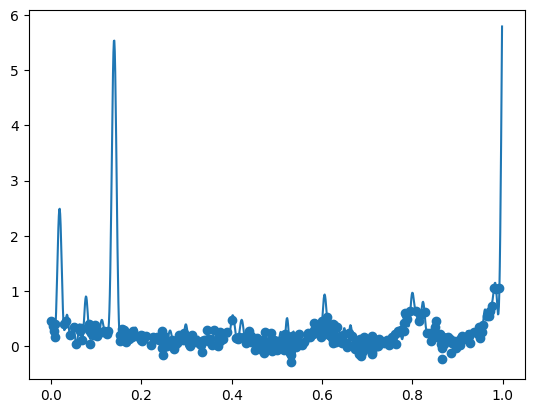

Best Result: x=0.531, y=-0.298


In [1]:
from math import sin, cos, pi
from numpy import arange, vstack, argmin, asarray
from numpy.random import normal, random
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from warnings import catch_warnings, simplefilter
from matplotlib import pyplot
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

# Objective function
def objective(x, noise=0.1):
    noise = normal(loc=0, scale=noise)
    return ((x-0.6) ** 2 + x ** 2 * cos(5 * pi * x) ** 6.0) + noise

# Surrogate function
def surrogate(model, X):
    with catch_warnings():
        simplefilter("ignore")
        return model.predict(X, return_std=True)

# LCB (Lower Confidence Bound) acquisition function
def acquisition(X, Xsamples, model, kappa=1.96):
   # calculate the best surrogate score found so far
    yhat, _ = surrogate(model, X)
    best = max(yhat)
    mu, std = surrogate(model, Xsamples)
    scores = mu - kappa * std  # Lower confidence bound
    return scores

# Optimize the acquisition function
def opt_acquisition(X, y, model):
#    Xsamples = random(100).reshape(-1, 1)
    Xsamples = random(100)
    Xsamples = Xsamples.reshape(len(Xsamples), 1)
    scores = acquisition(X, Xsamples, model)
    ix = argmin(scores)  # Select the point with the lowest acquisition score
    return Xsamples[ix, 0]

# Plot function
def plot(X, y, model, img_name='plot'):
    pyplot.scatter(X, y)
    # Xsamples = asarray(arange(0, 1, 0.001)).reshape(-1, 1)
    Xsamples = asarray(arange(0, 1, 0.001))
    Xsamples = Xsamples.reshape(len(Xsamples), 1)
    ysamples, _ = surrogate(model, Xsamples)
    pyplot.plot(Xsamples, ysamples)
    pyplot.show()
    pyplot.close()

# Sample the domain sparsely with noise
X = random(200).reshape(-1, 1)
y = asarray([objective(x) for x in X]).reshape(-1, 1)

# Define the model
kernel = RBF(length_scale=0.1, length_scale_bounds=(1e-2, 10.0))
model = GaussianProcessRegressor(kernel=kernel, alpha=1e-6, n_restarts_optimizer=2)

# Fit the model using X, y
model.fit(X, y)

# Plot before optimization
plot(X, y, model, img_name='gp_initial_model')

# Perform the optimization process
for i in range(100):
    # Select the next point to sample
    x = opt_acquisition(X, y, model)
    # Sample the point
    actual = objective(x)
    # Summarize the finding
    est, _ = surrogate(model, [[x]])
    print('>x=%.3f, f()=%.3f, actual=%.3f' % (x, est[0], actual))
    # Add the data to the dataset
    X = vstack((X, [[x]]))
    y = vstack((y, [[actual]]))
    # Update the model
    model.fit(X, y)

# Plot final result
plot(X, y, model, img_name='gp_result_model')

# Best result
ix = argmin(y)
print('Best Result: x=%.3f, y=%.3f' % (X[ix].item(), y[ix].item()))